Week Aug 2 - Aug 5

Tasks this week:
1. Go thorugh all parts of code carefully.
2. Prototypes init as mean.
3. More datasets.
4. Transformer.

Week Aug 17 - Aug 24

Modify PL loss
1. Normalize
2. Student t distribution to replace distance for embedding

In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import vanilla_vae

import igraph as ig
from sklearn.decomposition import TruncatedSVD
from anndata import AnnData

Dataset Loading, Label & Hierarchical encoding & Preprocessing

In [2]:
# Load dataset // No problem
# dataset = sc.read('./datasets/filtered_500_strict.h5ad')
# dataset = sc.read('./datasets/filtered_data_500.h5ad')
dataset = sc.read("/Volumes/SSD/global.h5ad")
# dataset = sc.read("../global.h5ad")
# Get all celltypes. // No problem
list_celltypes = dataset.obs['Manually_curated_celltype'].unique().tolist()
# These are the celltypes that we're going to remove. // No problem
list_celltypes = list(filter(lambda x: x not in ['Mast cells', 'pDC','Progenitor', 'Erythroid', 'Megakaryocytes'], list_celltypes))
# Remove the doublets // No problem
list_filtered_celltypes = list(filter(lambda x: 'doublets' not in x, list_celltypes))
# Remove celltypes from the dataset // No problem
dataset = dataset[dataset.obs['Manually_curated_celltype'].isin(list_filtered_celltypes)]

# Label encoder // No problem
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])

# Get the list of filtered celltypes // No problem
list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
# Transform list of filtered celltypes to list of numbers // No problem
list_num_ct = encoder_celltype.transform(list_ct)
# These are higher level celltypes // No problem
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

# The label encoder for inner nodes (High level celltype) // No problem
encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

# The transform function for both inner nodes and detailed celltypes // No problem
def transfrom(x):
    if x in list_inner_nodes:
        return encoder_celltype_inner.transform([x])[0] + len(list_ct)
    else:
        return encoder_celltype.transform([x])[0]

# Initialize the hierarchical tree // No problem
g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = np.append(encoder_celltype.inverse_transform(list(range(len(list_ct)))), encoder_celltype_inner.inverse_transform(list(range(len(list_inner_nodes)))))
g.add_edges([(transfrom('Cross-tissue Immune Cell Atlas'), transfrom('B cell')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('Myeloid')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('T & Innate lymphoid cells'))])
g.add_edges([(transfrom('B cell'), transfrom('ABCs')),
             (transfrom('B cell'), transfrom('Germinal center B cell')),
             (transfrom('B cell'), transfrom('Memory B cells')),
             (transfrom('B cell'), transfrom('Naive B cells')),
             (transfrom('B cell'), transfrom('Plasma cells')),
             (transfrom('B cell'), transfrom('Plasmablasts')),
             (transfrom('B cell'), transfrom('Pre-B')),
             (transfrom('B cell'), transfrom('Pro-B'))])
g.add_edges([(transfrom('Germinal center B cell'), transfrom('GC_B (I)')),
             (transfrom('Germinal center B cell'), transfrom('GC_B (II)'))])
g.add_edges([(transfrom('Myeloid'), transfrom('Cycling')),
             (transfrom('Myeloid'), transfrom('Dendritic cell')),
             (transfrom('Myeloid'), transfrom('Macrophages')),
             (transfrom('Myeloid'), transfrom('Monocytes'))])
g.add_edges([(transfrom('Dendritic cell'), transfrom('DC1')),
             (transfrom('Dendritic cell'), transfrom('DC2')),
             (transfrom('Dendritic cell'), transfrom('migDC'))])
g.add_edges([(transfrom('Macrophages'), transfrom('Alveolar macrophages')),
             (transfrom('Macrophages'), transfrom('Erythrophagocytic macrophages')),
             (transfrom('Macrophages'), transfrom('Intermediate macrophages')),
             (transfrom('Macrophages'), transfrom('Intestinal macrophages'))])
g.add_edges([(transfrom('Monocytes'), transfrom('Classical monocytes')),
             (transfrom('Monocytes'), transfrom('Nonclassical monocytes'))])
g.add_edges([(transfrom('T & Innate lymphoid cells'), transfrom('CD4')),
             (transfrom('T & Innate lymphoid cells'), transfrom('CD8')),
             (transfrom('T & Innate lymphoid cells'), transfrom('Cycling T&NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('ILC3')),
             (transfrom('T & Innate lymphoid cells'), transfrom('NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('T_CD4/CD8'))])
g.add_edges([(transfrom('CD4'), transfrom('T Naive')),
             (transfrom('CD4'), transfrom('Teffector/EM_CD4')),
             (transfrom('CD4'), transfrom('Tfh')),
             (transfrom('CD4'), transfrom('Tregs')),
             (transfrom('CD4'), transfrom('Trm_Th1/Th17'))])
g.add_edges([(transfrom('CD8'), transfrom('MAIT')),
             (transfrom('CD8'), transfrom('Tem/emra_CD8')),
             (transfrom('CD8'), transfrom('Tgd_CRTAM+')),
             (transfrom('CD8'), transfrom('Tissue-resident memory T (Trm) cells')),
             (transfrom('CD8'), transfrom('Tnaive/CM_CD8')),
             (transfrom('CD8'), transfrom('Trm_Tgd'))])
g.add_edges([(transfrom('NK'), transfrom('NK_CD16+')),
             (transfrom('NK'), transfrom('NK_CD56bright_CD16-'))])
g.add_edges([(transfrom('T Naive'), transfrom('Tnaive/CM_CD4')),
             (transfrom('T Naive'), transfrom('Tnaive/CM_CD4_activated'))])
g.add_edges([(transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm/em_CD8')),
             (transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm_gut_CD8')),])

# g.write('tree', format='gml')
layout = g.layout("kamada_kawai")
ig.plot(g, layout=layout, vertex_label=g.vs["name"], vertex_label_size=10, vertex_size=15, bbox=(1000, 1000), margin=100, vertex_color='white')

# return the shortest distance between two nodes // No problem
def get_shortest_dist(node_1, node_2, graph):
    return len(graph.get_shortest_paths(node_1, node_2)[0])-1
 
# Construct the distance matrix, init with 0 // No problem
dist_df = pd.DataFrame(0, index=np.arange(len(list_num_ct)), columns=np.arange(len(list_num_ct)))
for i in range(len(list_num_ct)):
    for j in range(len(list_num_ct)):
        dist_df.iloc[i, j]=get_shortest_dist(i, j, g)

# Convert to tensor // No problem
D = dist_df
D = torch.tensor(D.values, dtype=float)

# Train test split // No problem
train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=test_subsampler)

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:
# Get number of cells by cell type
def get_num_by_ct(label, dataset):
    return len(dataset.obs[dataset.obs['Manually_curated_celltype'] == label])

weights = []
for i in range(len(list_num_ct)):
    weights.append(get_num_by_ct(encoder_celltype.inverse_transform([i])[0], dataset))
weights = torch.tensor(weights, dtype=float)

In [4]:
# Pytorch version of the 3 fully connected layers
# No problem
class Net(nn.Module):
    def __init__(self, mode, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(Net, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# No problem
class PL(nn.Module):
    def __init__(self, centers, weights, vars):
        super(PL, self).__init__()
        self.centers = centers
        self.weights = weights
        self.vars = vars

    def forward(self, mapping, labels):
        # Find prototype by labels
        targets = torch.index_select(self.centers, 0, labels)
        # Sum the distance between each point and its prototype
        weights = torch.index_select(self.weights, 0, labels)
        log_vars = torch.log(torch.index_select(self.vars, 0, labels))
        # dist = torch.norm(mapping - targets, dim=1)/weights
        # return torch.sum(dist)/mapping.shape[0]
        likelihood = -helper_fns.log_likelihood_student(mapping, targets, log_vars)/weights
        return torch.sum(likelihood)/mapping.shape[0]
        # return torch.sum(likelihood)/mapping.shape[0]

In [5]:
embedding_dim = 16

In [6]:
def train(mode, loss_mode, epochs=30, cuda=1):
    if torch.cuda.is_available():
        D_metric = D.cuda()
    else:
        D_metric = D
    # A simple neural network no problem
    if mode == 'Net':
        if torch.cuda.is_available():
            model = Net(mode, 128, 32, 37).cuda()
        else:
            model = Net(mode, 128, 32, 37)
    # Learnt prototype & Simple neural network encoder no problem
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            model = Net(mode, 128, 32, embedding_dim).cuda()
            centers = []
            vars = []
            for i in range(len(list_num_ct)):
                out = model(torch.tensor(dataset[dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0]].X))
                centers.append(np.array(torch.mean(out, dim=0)))
                vars.append(np.array(torch.var(out, dim=0)))
            centers = torch.tensor(centers, dtype=float).cuda()
            vars = torch.tensor(vars, dtype=float).cuda()
            model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                    prototypes=centers, vars=vars, embedding_dim=embedding_dim, device='cuda').cuda()
        else:
            model = Net(mode, 128, 64, 32, 16, embedding_dim)
            centers = []
            vars = []
            for i in range(len(list_num_ct)):
                out = model(torch.tensor(dataset[dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0]].X))
                centers.append(np.array(torch.mean(out, dim=0).detach()))
                vars.append(np.array(torch.var(out, dim=0).detach()))
            centers = torch.tensor(centers, dtype=float)
            vars = torch.tensor(vars, dtype=float)
            model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                    prototypes=centers, vars=vars, embedding_dim=embedding_dim, device='cpu')
    # Cross entropy loss no problem
    criterion = nn.CrossEntropyLoss()
    # Distortion loss no problem
    delta = DistortionLoss(D_metric)
    opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    # Train & Test model, no problem
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)

        model.train()
        t0 = time.time()
        for batch in dataloader_training:
            if torch.cuda.is_available():
                x = batch.X.cuda()
                y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            else:
                x = batch.X
                y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor)
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                out = model(x)
            elif mode == 'Proto_Net':
                out, embeddings = model(x)
            opt.zero_grad()
            xe_loss = criterion(out, y)
            loss = xe_loss
            if 'pl' in loss_mode:
                # print(model.prototypes.shape)
                # print(model.vars.shape)
                
                pl_loss = PL(centers = model.prototypes.data, weights=weights, vars=model.vars)
                pl_loss_ = pl_loss(embeddings, y)
                loss = loss + 1000*pl_loss_
            if 'disto' in loss_mode:
                disto_loss = delta(model.prototypes)
                loss = loss + disto_loss
            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
        vars = []
        if mode == 'Proto_Net':
            if torch.cuda.is_available():
                for i in range(len(list_num_ct)):
                    out, embeddings = model(torch.tensor(dataset[dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0]].X)).cpu()
                    vars.append(np.array(torch.var(embeddings, dim=0).detach().cpu()))
                model.vars = torch.tensor(vars, dtype=float).cuda()
            else:
                for i in range(len(list_num_ct)):
                    out, embeddings = model(torch.tensor(dataset[dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0]].X))
                    # out = model(dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0])
                    vars.append(np.array(torch.var(embeddings, dim=0).detach()))
                model.vars = torch.tensor(vars, dtype=float)
        t1 = time.time()
        
        print('Train ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        t0 = time.time()
        for batch in dataloader_testing:
            if torch.cuda.is_available():
                x = batch.X.cuda()
                y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            else:
                x = batch.X
                y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor)
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                with torch.no_grad():
                    out = model(x)
            elif mode == 'Proto_Net':
                with torch.no_grad():
                    out, embeddings = model(x)
            pred = out.detach()
            ER_meter.add(pred.cpu(),y)
        t1 = time.time()
        print('Test ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))
    return model

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(mode, model):
    y_test = dataset[test_indices].obs['Manually_curated_celltype']
    if mode == 'Net':
        if torch.cuda.is_available():
            y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred = model(torch.tensor(dataset[test_indices].X))
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X))
    y_pred = y_pred.detach().cpu().numpy()
    pred = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))
    cm=confusion_matrix(y_test, pred)
    # Normalise
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                        yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show(block=False)

def plot_distance_matrix(mode, model):
    y_test = encoder_celltype.transform(dataset[test_indices].obs['Manually_curated_celltype'])
    if mode == 'Net':
        if torch.cuda.is_available():
            y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred = model(torch.tensor(dataset[test_indices].X))
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X))
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = y_pred.argmax(axis=1)
    dist_list = []
    for i in range(len(y_pred)):
        distance = dist_df.iloc[y_pred[i], y_test[i]]
        dist_list.append(distance)
    print(np.mean(np.array(dist_list)))
    sns.displot(dist_list)
    plt.show(block=False)



/var/folders/hk/lwlgjk2975n6fqbwkl1b7ny40000gq/T/ipykernel_94727/3178807822.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  centers = torch.tensor(centers, dtype=float)


Epoch 1
Train ER 30.77, time 5.9s
Test ER 24.56, time 0.6s
Epoch 2
Train ER 21.43, time 5.9s
Test ER 20.19, time 0.5s
Epoch 3
Train ER 17.04, time 5.9s
Test ER 15.58, time 0.5s
Epoch 4
Train ER 14.07, time 5.9s
Test ER 13.46, time 0.6s
Epoch 5
Train ER 12.61, time 5.9s
Test ER 12.25, time 0.6s
Epoch 6
Train ER 11.66, time 5.9s
Test ER 11.64, time 0.5s
Epoch 7
Train ER 11.15, time 5.9s
Test ER 11.18, time 0.6s
Epoch 8
Train ER 10.84, time 5.9s
Test ER 10.96, time 0.5s
Epoch 9
Train ER 10.61, time 5.9s
Test ER 10.76, time 0.5s
Epoch 10
Train ER 10.41, time 5.9s
Test ER 10.61, time 0.6s
Epoch 11
Train ER 10.26, time 5.9s
Test ER 10.62, time 0.6s
Epoch 12
Train ER 10.08, time 5.9s
Test ER 10.24, time 0.5s
Epoch 13
Train ER 9.88, time 5.8s
Test ER 10.14, time 0.6s
Epoch 14
Train ER 9.71, time 5.8s
Test ER 9.92, time 0.5s
Epoch 15
Train ER 9.56, time 5.8s
Test ER 9.80, time 0.6s
Epoch 16
Train ER 9.39, time 5.9s
Test ER 9.69, time 0.5s
Epoch 17
Train ER 9.24, time 5.8s
Test ER 9.51, time 0.6

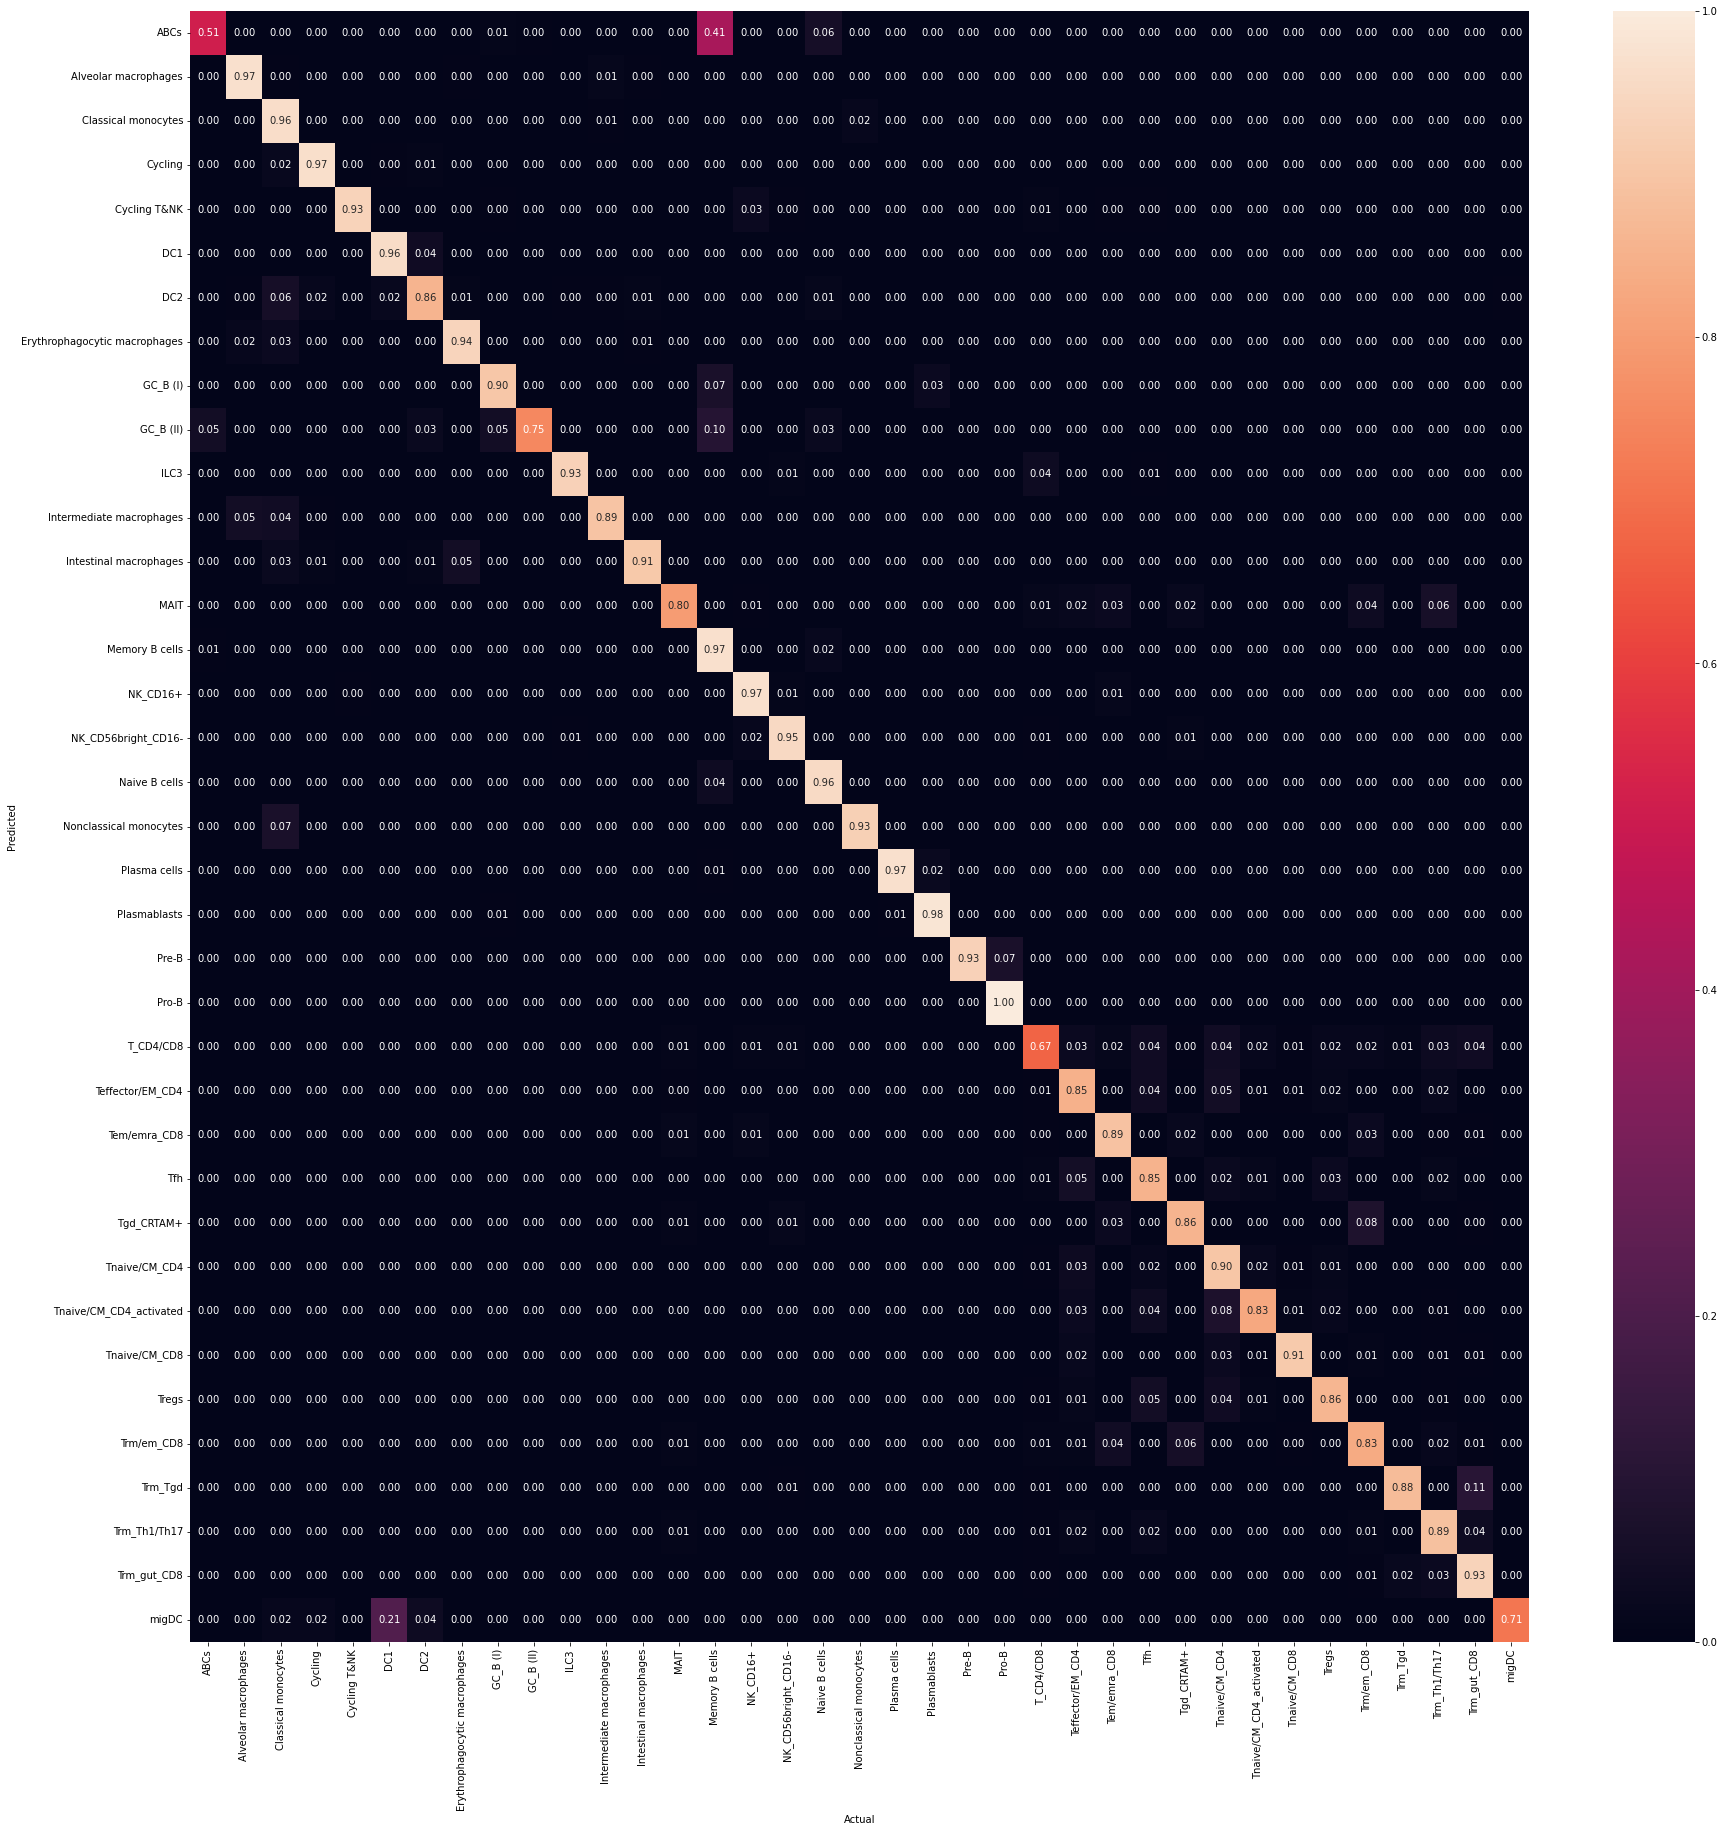

In [8]:
mode='Proto_Net'
loss_mode='disto_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)
torch.save(model.state_dict(), './models/'+mode+'_'+loss_mode+'.pt')

POPV Dataset

In [9]:
dataset_popv = sc.read("/Volumes/SSD/popv_immune.h5ad")
# Load dataset
list_celltypes_popv = dataset_popv.obs['cell_type'].unique().tolist()

# Label encoder // No problem
encoder_celltype_popv = LabelEncoder()
encoder_celltype_popv.fit(dataset_popv.obs['cell_type'])

sc.pp.normalize_total(dataset_popv, 1e4)
sc.pp.log1p(dataset_popv)
dataset_popv_pca = AnnData(pca.transform(dataset_popv.X))
dataset_popv_pca.obs = dataset.obs
dataset_popv = dataset_popv_pca

ValueError: X has 58559 features, but TruncatedSVD is expecting 36601 features as input.

In [18]:
genes_popv = dataset_popv.var_names

In [19]:
dataset = sc.read("/Volumes/SSD/global.h5ad")
genes_celltypist = dataset.var_names

In [72]:
print(list(genes_popv))

['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267', 'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613', 'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000233750', 'ENSG00000268903', 'ENSG00000269981', 'ENSG00000239906', 'ENSG00000241860', 'ENSG00000222623', 'ENSG00000241599', 'ENSG00000279928', 'ENSG00000279457', 'ENSG00000273874', 'ENSG00000228463', 'ENSG00000236679', 'ENSG00000236601', 'ENSG00000237094', 'ENSG00000269732', 'ENSG00000284733', 'ENSG00000233653', 'ENSG00000250575', 'ENSG00000278757', 'ENSG00000230021', 'ENSG00000235146', 'ENSG00000225972', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000278791', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000248527', 'ENSG00000198744', 'ENSG00000268663', 'ENSG00000284662', 'ENSG00000229376', 'ENSG00000228327', 'ENSG00000223181', 'ENSG00000229905', 'ENSG00000237491', 'ENSG00000285268', 'ENSG00000230092', 'ENSG00000177757', 'ENSG00000228794', 'ENSG00000225880', 'ENSG000002

In [71]:
print(list(genes_celltypist))

['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3', 'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1', 'OR4F29', 'AC114498.1', 'OR4F16', 'AL669831.2', 'LINC01409', 'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C', 'AL645608.6', 'AL645608.2', 'AL645608.4', 'LINC02593', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'AL645608.7', 'HES4', 'ISG15', 'AL645608.1', 'AGRN', 'AL645608.5', 'AL645608.8', 'RNF223', 'C1orf159', 'AL390719.3', 'LINC01342', 'AL390719.2', 'TTLL10-AS1', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'B3GALT6', 'C1QTNF12', 'AL162741.1', 'UBE2J2', 'LINC01786', 'SCNN1D', 'ACAP3', 'PUSL1', 'INTS11', 'AL139287.1', 'CPTP', 'TAS1R3', 'DVL1', 'MXRA8', 'AURKAIP1', 'CCNL2', 'MRPL20-AS1', 'MRPL20', 'AL391244.2', 'ANKRD65', 'AL391244.1', 'TMEM88B', 'LINC01770', 'VWA1', 'ATAD3C', 'ATAD3B', 'ATAD3A', 'TMEM240', 'SSU72', 'AL645728.1', 'FNDC10', 'AL691432.4', 'AL691432.2', 'MIB2', 'MMP23B', 'CDK11B', 'FO704657.1', 'SLC35E2B', 'CDK11A', 'SLC35E2A', 'NADK', 'GNB1',

In [69]:
print("WASH7P" in genes_celltypist)

False


In [23]:
import biomart

In [51]:
server = biomart.BiomartServer('http://uswest.ensembl.org/biomart')

In [80]:
def get_ensembl_mappings():                                   
    # Set up connection to server
    server = biomart.BiomartServer('http://uswest.ensembl.org/biomart')
    mart = server.datasets['hsapiens_gene_ensembl']
                                                                                
    # List the types of data we want                                            
    # attributes = ['ensembl_transcript_id', 'mgi_symbol', 'ensembl_gene_id', 'ensembl_peptide_id']
    # attributes = ['hgnc_symbol', 'ensembl_gene_id', 'gene_biotype']
    attributes = ['hgnc_symbol', 'ensembl_gene_id']
                                                                                
    # Get the mapping between the attributes
    response = mart.search({'attributes': attributes})
    data = response.raw.data.decode('ascii')
                                                                                
    ensembl_to_genesymbol = {}
    # Store the data in a dict                                                  
    for line in data.splitlines():
        line = line.split('\t')
        # The entries are in the same order as in the `attributes` variable
        hgnc_symbol = line[0]
        ensembl_gene_id = line[1]
        # gene_biotype = line[2]
                                                                                
        # Some of these keys may be an empty string. If you want, you can 
        # avoid having a '' key in your dict by ensuring the 
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        ensembl_to_genesymbol[hgnc_symbol] = ensembl_gene_id
        # ensembl_to_genesymbol[ensembl_gene] = gene_symbol
        # ensembl_to_genesymbol[ensembl_peptide] = gene_symbol
         
    return ensembl_to_genesymbol
    # return response, data

In [81]:
ensembl_to_genesymbol = get_ensembl_mappings()

In [83]:
ensembl_to_genesymbol.keys()

dict_keys(['MT-TF', 'MT-RNR1', 'MT-TV', 'MT-RNR2', 'MT-TL1', 'MT-ND1', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-ND2', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-CO1', 'MT-TS1', 'MT-TD', 'MT-CO2', 'MT-TK', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-TG', 'MT-ND3', 'MT-TR', 'MT-ND4L', 'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE', 'MT-CYB', 'MT-TT', 'MT-TP', '', 'KIR2DL3', 'KIR2DL1', 'KIR3DP1', 'LILRP1', 'KIR3DL2', 'LILRP2', 'KIR2DS4', 'INTS3', 'PCMTD2', 'KIR2DS5', 'LINC02109', 'KIR2DS3', 'KIR2DL4', 'KIR2DP1', 'NCR1', 'KIR2DL2', 'KIR3DL3', 'KIR3DL1', 'FCAR', 'OPRL1', 'NPBWR2', 'KIR2DS2', 'MYT1', 'KIR2DL5B', 'KIR3DS1', 'KIR2DL5A', 'KIR2DS1', 'SBNO2', 'PTCHD3', 'DNAH10', 'ODAD2P1', 'FAM210CP', 'TRIAP1P1', 'SNTG2', 'OR9G4', 'OR5G3', 'OR9G3P', 'OR5G1P', 'OR5G4P', 'OR5G5P', 'OR9G2P', 'OR9G1', 'GEMIN2P1', 'OR9G9', 'GATAD2B', 'LINC02735', 'CCDC92', 'KRT18P40', 'ZNF430', 'RNA5-8SN5', 'ZNF85', 'SLC27A3', 'BNIP3P24', 'ZNF66', 'PIWIL1', 'KRTAP9-2', 'KRTAP9-10P', 'KRTAP9-4', 'KRTAP9-6', 'KR

In [138]:
not_found = []
found_hgnc = []
found_ensembl = []
for i in range(len(list(genes_celltypist))):
    try:
        a = ensembl_to_genesymbol[genes_celltypist[i]]
        if a not in genes_popv:
            not_found.append(genes_celltypist[i])
        else:
            found_hgnc.append(genes_celltypist[i])
            found_ensembl.append(a)
    except KeyError:
        not_found.append(genes_celltypist[i])

In [158]:
# filter the anndata by the found_ensembl genes
dataset_popv_filtered = dataset_popv[:,found_ensembl]
dataset_celltypist_filtered = dataset[:,found_hgnc]